```
# Copyright 2023 by the author(s) of CHI2023 Late Breaking Work
# "Exploring Physiological Correlates of Visual Complexity Adaptation:
# Insights from EDA, ECG, and EEG Data for Adaptation Evaluation in VR
# Adaptive Systems". All rights reserved.
#
# Use of this source code is governed by a GPLv3 license that
# can be found in the LICENSE file.
```

In [1]:
import tqdm
import pandas as pd
import numpy as np
import neurokit2 as nk

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'''\usepackage{libertine}\usepackage{fontawesome5}\usepackage[dvipsnames]{xcolor}'''
plt.rcParams['ps.usedistiller'] = 'xpdf'
import seaborn as sns
sns.set_theme(style='ticks')

import warnings
warnings.filterwarnings('ignore')

from lbw import get_event_intervals

In [10]:
def load_feedback(pid):
    dfFeedback = pd.read_csv(f"./data/ID{pid}-feedback.csv")
    dfState = pd.read_csv(f"./data/ID{pid}-state.csv")
    dfAdaptation = pd.read_csv(f"./data/ID{pid}-adaptation.csv")

    intervals, workloads = get_event_intervals(dfAdaptation)

    for idx, interval in enumerate(intervals):
        dfFeedback.loc[(dfFeedback['Time'] >= interval[0]) & (dfFeedback['Time'] <= interval[1]), 'workload'] = workloads[idx]
        dfFeedback.loc[(dfFeedback['Time'] >= interval[0]) & (dfFeedback['Time'] <= interval[1]), 'interval_id'] = idx
    dfFeedback = dfFeedback[dfFeedback['workload'].notna()]

    dfFeedback.loc[dfFeedback[(dfFeedback.Time > dfState['Time'][2]) & (dfFeedback.Time < dfState['Time'][2+1])].index, 'BlockNumber']   = dfState['BlockNumber'][2]
    dfFeedback.loc[dfFeedback[(dfFeedback.Time > dfState['Time'][4]) & (dfFeedback.Time < dfState['Time'][4+1])].index, 'BlockNumber']   = dfState['BlockNumber'][4]
    dfFeedback.loc[dfFeedback[(dfFeedback.Time > dfState['Time'][6]) & (dfFeedback.Time < dfState['Time'][6+1])].index, 'BlockNumber']   = dfState['BlockNumber'][6]
    dfFeedback.loc[dfFeedback[(dfFeedback.Time > dfState['Time'][8]) & (dfFeedback.Time < dfState['Time'][8+1])].index, 'BlockNumber']  = dfState['BlockNumber'][8]
    dfFeedback.loc[dfFeedback[(dfFeedback.Time > dfState['Time'][10]) & (dfFeedback.Time < dfState['Time'][10+1])].index, 'BlockNumber'] = dfState['BlockNumber'][10]
    dfFeedback.loc[dfFeedback[(dfFeedback.Time > dfState['Time'][12]) & (dfFeedback.Time < dfState['Time'][12+1])].index, 'BlockNumber'] = dfState['BlockNumber'][12]

    # dfFeedback = dfFeedback.dropna()
    dfFeedback = dfFeedback.sort_values(by="Time")
    return dfFeedback

def load_flow(pid):

    dfFlow = pd.read_csv(f"./data/ID{pid}-flow.csv")
    dfVisitor = pd.read_csv(f"./data/ID{pid}-visitor.csv")
    dfMerged = pd.merge(dfFlow, dfVisitor[["Name", "Type"]], on="Name", how="outer")

    dfState = pd.read_csv(f"./data/ID{pid}-state.csv")
    dfAdaptation = pd.read_csv(f"./data/ID{pid}-adaptation.csv")

    intervals, workloads = get_event_intervals(dfAdaptation)

    for idx, interval in enumerate(intervals):
        dfMerged.loc[(dfMerged['Time'] >= interval[0]) & (dfMerged['Time'] <= interval[1]), 'workload'] = workloads[idx]
        dfMerged.loc[(dfMerged['Time'] >= interval[0]) & (dfMerged['Time'] <= interval[1]), 'interval_id'] = idx
    dfMerged = dfMerged[dfMerged['workload'].notna()]

    dfMerged.loc[dfMerged[(dfMerged.Time > dfState['Time'][2]) & (dfMerged.Time < dfState['Time'][2+1])].index, 'BlockNumber']   = dfState['BlockNumber'][2]
    dfMerged.loc[dfMerged[(dfMerged.Time > dfState['Time'][4]) & (dfMerged.Time < dfState['Time'][4+1])].index, 'BlockNumber']   = dfState['BlockNumber'][4]
    dfMerged.loc[dfMerged[(dfMerged.Time > dfState['Time'][6]) & (dfMerged.Time < dfState['Time'][6+1])].index, 'BlockNumber']   = dfState['BlockNumber'][6]
    dfMerged.loc[dfMerged[(dfMerged.Time > dfState['Time'][8]) & (dfMerged.Time < dfState['Time'][8+1])].index, 'BlockNumber']  = dfState['BlockNumber'][8]
    dfMerged.loc[dfMerged[(dfMerged.Time > dfState['Time'][10]) & (dfMerged.Time < dfState['Time'][10+1])].index, 'BlockNumber'] = dfState['BlockNumber'][10]
    dfMerged.loc[dfMerged[(dfMerged.Time > dfState['Time'][12]) & (dfMerged.Time < dfState['Time'][12+1])].index, 'BlockNumber'] = dfState['BlockNumber'][12]

    dfMerged = dfMerged.sort_values(by="Time")
    return dfMerged[dfMerged['BlockNumber'].notna()]

def extract_nback_acc(pid, df):
    df_features = pd.DataFrame()
    intervals = df.interval_id.unique()
    for interval_id in intervals:
        df_current = df[df.interval_id == interval_id]

        corrects = df_current.IsCorrect
        totalAction = len(corrects)
        correctAction = len(corrects[corrects == True])
        accuracy = correctAction / totalAction

        df_features = df_features.append(pd.DataFrame.from_dict([{
            'pid': pid,
            'workload': df_current['workload'].iloc[0],
            'interval': interval_id,
            'nbackAccuracy': accuracy,
        }]))
    return df_features

def extract_add_acc(pid, df):
    df_features = pd.DataFrame()
    intervals = df.interval_id.unique()
    for interval_id in intervals:
        df_current = df[df.interval_id == interval_id]

        truePositive = len(df_current[(df_current.HasTicket == False) & (df_current.Type == "down")]) # hits
        trueNegatives = len(df_current[(df_current.HasTicket == True) & (df_current.Type.isna())])
        total = len(df_current)
        vdAcc = (truePositive + trueNegatives) / total

        df_features = df_features.append(pd.DataFrame.from_dict([{
            'pid': pid,
            'workload': df_current['workload'].iloc[0],
            'interval': interval_id,
            'adAccuracy': vdAcc,
        }]))
    return df_features

In [11]:
pid_valid = [4, 5, 7, 9, 10, 11, 12, 13]
df_feedbacks = {}
df_flows = {}

for pid in tqdm.tqdm(pid_valid):
    df = load_feedback(pid)
    df_feedbacks[pid] = df
    df = load_flow(pid)
    df_flows[pid] = df

100%|██████████| 8/8 [00:00<00:00, 19.38it/s]


In [12]:
df = pd.DataFrame()
for pid in pid_valid:
    df_features1 = extract_nback_acc(pid, df_feedbacks[pid])
    df_features2 = extract_add_acc(pid, df_flows[pid])
    df = df.append(pd.merge(df_features1, df_features2, on=['pid', 'workload', 'interval']))
df

,pid,workload,interval,nbackAccuracy,adAccuracy
0,4,low,0.0,0.933333,1.000000
1,4,high,1.0,0.833333,0.727273
0,5,low,0.0,0.900000,0.571429
1,5,high,1.0,0.857143,0.833333
2,5,low,2.0,0.800000,1.000000
...,...,...,...,...,...
7,13,low,10.0,1.000000,0.937500
8,13,high,11.0,0.857143,0.882353
9,13,low,12.0,1.000000,0.933333
10,13,high,13.0,1.000000,0.666667


In [17]:
df['nbackAccuracy'] = df['nbackAccuracy'] * 100
df['adAccuracy'] = df['adAccuracy'] * 100

In [20]:
df.to_csv('processed/accuracy.csv', index=False)

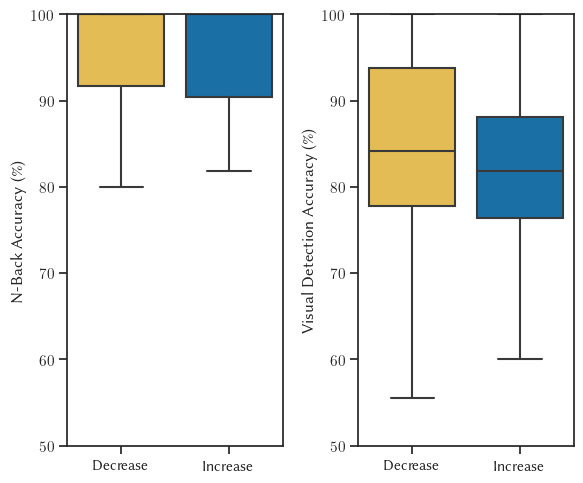

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(6, 5))
colors = list({'yellow' : '#FBC63D', 'blue': '#0376BB'}.values())
sns.boxplot(x='workload', y='nbackAccuracy', data=df, ax=axes[0], palette=colors, showfliers=False)
sns.boxplot(x='workload', y='adAccuracy', data=df, ax=axes[1], palette=colors, showfliers=False)

axes[0].set_ylabel('N-Back Accuracy (\%)')
axes[1].set_ylabel('Visual Detection Accuracy (\%)')

axes[0].set_xticklabels(['Decrease', 'Increase'])
axes[1].set_xticklabels(['Decrease', 'Increase'])

axes[0].set_ylim(50, 100)
axes[1].set_ylim(50, 100)

axes[0].set_xlabel('')
axes[1].set_xlabel('')

plt.tight_layout()
plt.savefig('figures/fig4ecg.pdf')